# *(Brette & Guigon, 2003)*: Reliability of spike timing

Implementation of the paper:

- Brette R and E Guigon (2003). Reliability of Spike Timing Is a General Property of Spiking Model Neurons. Neural Computation 15, 279-308.

In [1]:
import brainpy as bp
import brainpy.math as bm
import matplotlib.pyplot as plt

In [2]:
assert bp.__version__ >= '2.0.2'

In [3]:
class ExternalInput(bp.DynamicalSystem):
  def __init__(self, num):
    super(ExternalInput, self).__init__()

    # parameters
    self.num = num

    # variables
    self.I = bm.Variable(bm.zeros(num))

In [4]:
class LinearLeakyModel(bp.NeuGroup):
  r"""A nonlinear leaky model.

  .. math::

     \tau \frac{d V}{d t}=-V+R I(t)

  """

  def __init__(self, size, inputs):
    super(LinearLeakyModel, self).__init__(size)
    # parameters
    self.tau = 33  # ms
    self.R = 200 / 1e3  # Ω
    self.Vt = 15  # mV
    self.Vr = -5  # mV
    self.sigma = 1.
    self.inputs = inputs

    # variables
    self.V = bm.Variable(bm.random.uniform(self.Vr, self.Vt, self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    f = lambda V, t: (-V + self.R * self.inputs.I) / self.tau
    g = lambda V, t: self.sigma * bm.sqrt(2. / self.tau)
    self.integral = bp.sdeint(f=f, g=g)

  def update(self, _t, _dt):
    self.inputs.update(_t, _dt)
    self.V.value = self.integral(self.V, _t, _dt)
    self.spike.value = self.V >= self.Vt
    self.V.value = bm.where(self.spike, self.Vr, self.V)

In [5]:
class NonlinearLeakyModel(bp.NeuGroup):
  r"""A nonlinear leaky model.
  
  .. math::
  
     \tau \frac{d V}{d t}=-a V^{3}+R I(t)
  
  """

  def __init__(self, size, inputs):
    super(NonlinearLeakyModel, self).__init__(size)
    # parameters
    self.tau = 33  # ms
    self.R = 200 / 1e3  # MΩ
    self.Vt = 15  # mV
    self.Vr = -5  # mV
    self.a = 4444 / 1e6  # V^(-2)
    self.sigma = 1.
    self.inputs = inputs

    # variables
    self.V = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    f = lambda V, t: (-self.a * V ** 3 + self.R * self.inputs.I) / self.tau
    g = lambda V, t: self.sigma * bm.sqrt(2. / self.tau)
    self.integral = bp.sdeint(f=f, g=g)

  def update(self, _t, _dt):
    self.inputs.update(_t, _dt)
    self.V.value = self.integral(self.V, _t, _dt)
    self.spike.value = self.V >= self.Vt
    self.V.value = bm.where(self.spike, self.Vr, self.V)

In [6]:
class NonLeakyModel(bp.NeuGroup):
  r"""A non-leaky model.

  .. math::

     \tau \frac{d V}{d t}=V I(t)+k

  """

  def __init__(self, size, inputs):
    super(NonLeakyModel, self).__init__(size)

    # parameters
    self.Vt = 1
    self.Vr = 0
    self.tau = 33  # ms
    self.k = 1
    self.sigma = 0.02
    self.inputs = inputs

    # variables
    self.V = bm.Variable(bm.random.uniform(self.Vr, self.Vt, self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    f = lambda V, t: (V * self.inputs.I + self.k) / self.tau
    g = lambda V, t: self.sigma * (2 / self.tau) ** .5
    self.integral = bp.sdeint(f, g, method='euler')

  def update(self, _t, _dt):
    self.inputs.update(_t, _dt)
    self.V.value = self.integral(self.V, _t, _dt)
    self.spike.value = self.V >= self.Vt
    self.V.value = bm.where(self.spike, self.Vr, self.V)

In [7]:
class PerfectIntegrator(bp.NeuGroup):
  r"""Integrate inputs.

  .. math::

     \tau \frac{d V}{d t}=f(t)

  where :math:`f(t)` is an input function.

  """

  def __init__(self, size, inputs):
    super(PerfectIntegrator, self).__init__(size)

    # parameters
    self.tau = 12.5  # ms
    self.Vt = 1
    self.Vr = 0
    self.sigma = 0.27
    self.inputs = inputs

    # variables
    self.V = bm.Variable(bm.random.uniform(self.Vr, self.Vt, self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))

    # functions
    f = lambda V, t: self.inputs.I / self.tau
    g = lambda V, t: self.sigma * (2 / self.tau) ** .5
    self.integral = bp.sdeint(f, g, method='euler')

  def update(self, _t, _dt):
    self.inputs.update(_t, _dt)
    self.V.value = self.integral(self.V, _t, _dt)
    self.spike.value = self.V >= self.Vt
    self.V.value = bm.where(self.spike, self.Vr, self.V)

In [8]:
def figure6(sigma=0.):
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.p = bm.linspace(0., 1., num)
      # variables
      self.B = bm.Variable(bm.zeros(1))

    def update(self, _t, _dt):
      self.B[:] = 30 * bm.sin(40 * bm.pi * _t / 1000)  # (1,)
      self.I.value = 85 + 40 * (1 - self.p) + self.p * self.B  # (num,)

  num = 500
  model = LinearLeakyModel(num, inputs=Noise(num))
  model.sigma = sigma

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(2000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 12)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

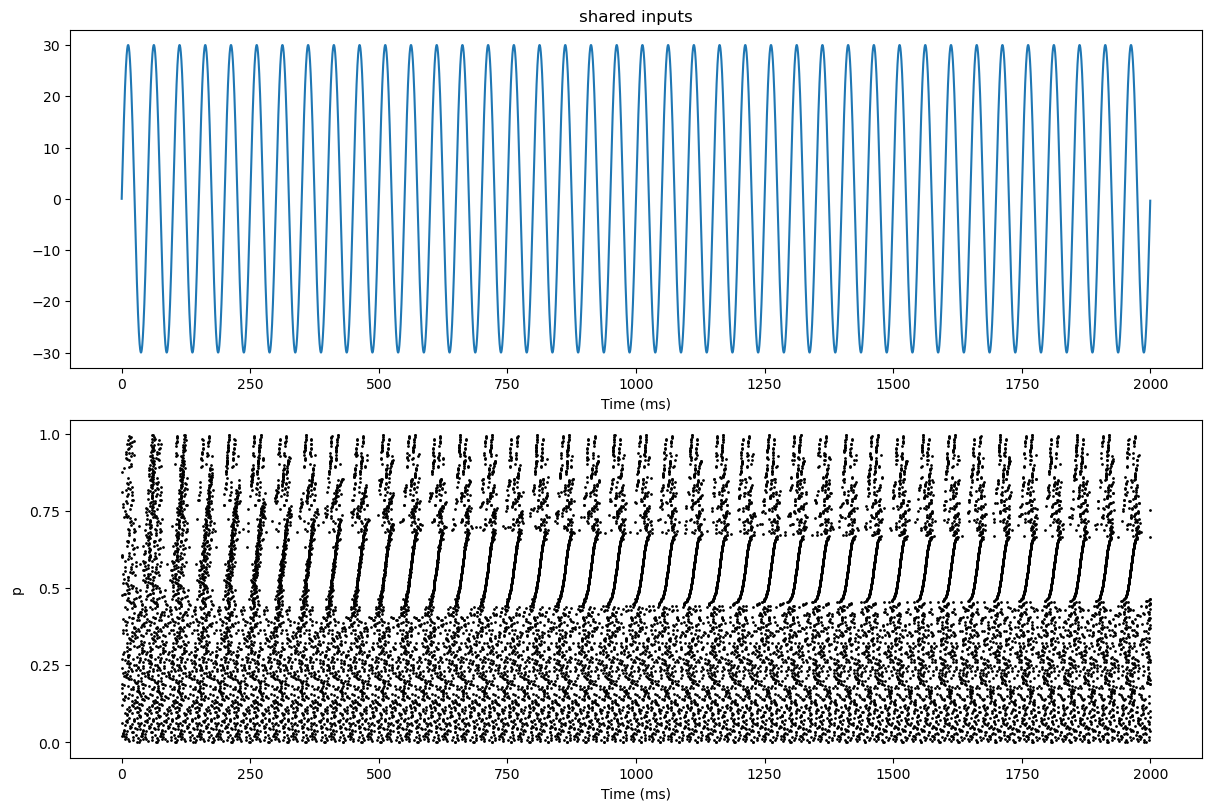

In [9]:
figure6(0.)

  0%|          | 0/20000 [00:00<?, ?it/s]

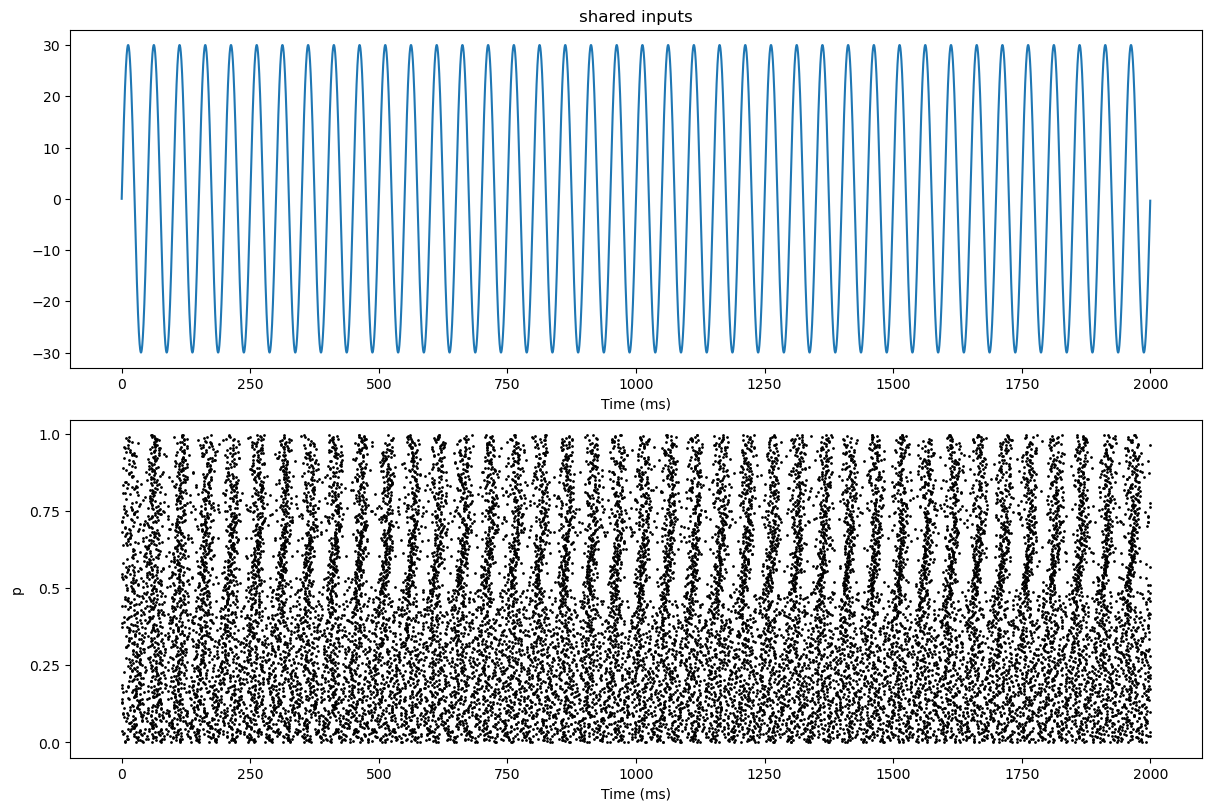

In [10]:
figure6(1.)

In [11]:
def figure7(sigma):
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.p = bm.linspace(0., 1., num)
      # variables
      self.B = bm.Variable(bm.zeros(1))

    def update(self, _t, _dt):
      self.B[:] = 150 * bm.sin(40 * bm.pi * _t / 1000)  # (1,)
      self.I.value = 150 + self.p * self.B  # (num,)

  num = 500
  model = NonlinearLeakyModel(num, inputs=Noise(num))
  model.sigma = sigma

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(1000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 8)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

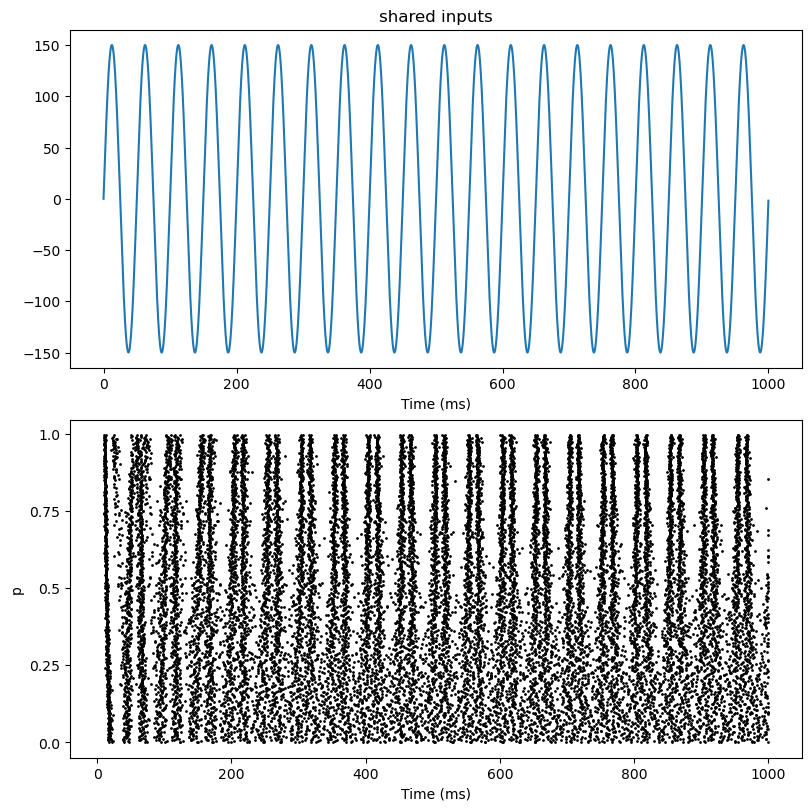

In [12]:
figure7(1.5)

In [13]:
def figure8(sigma):
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.p = bm.linspace(0., 1., num)
      # variables
      self.B = bm.Variable(bm.zeros(1))

    def update(self, _t, _dt):
      self.B[:] = 150 * bm.sin(40 * bm.pi * _t / 1000)  # (1,)
      self.I.value = 150 + self.p * self.B  # (num,)

  num = 500
  model = NonlinearLeakyModel(num, inputs=Noise(num))
  model.V.value = bm.random.uniform(model.Vr, model.Vt, model.num)
  model.sigma = sigma

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(1000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 8)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

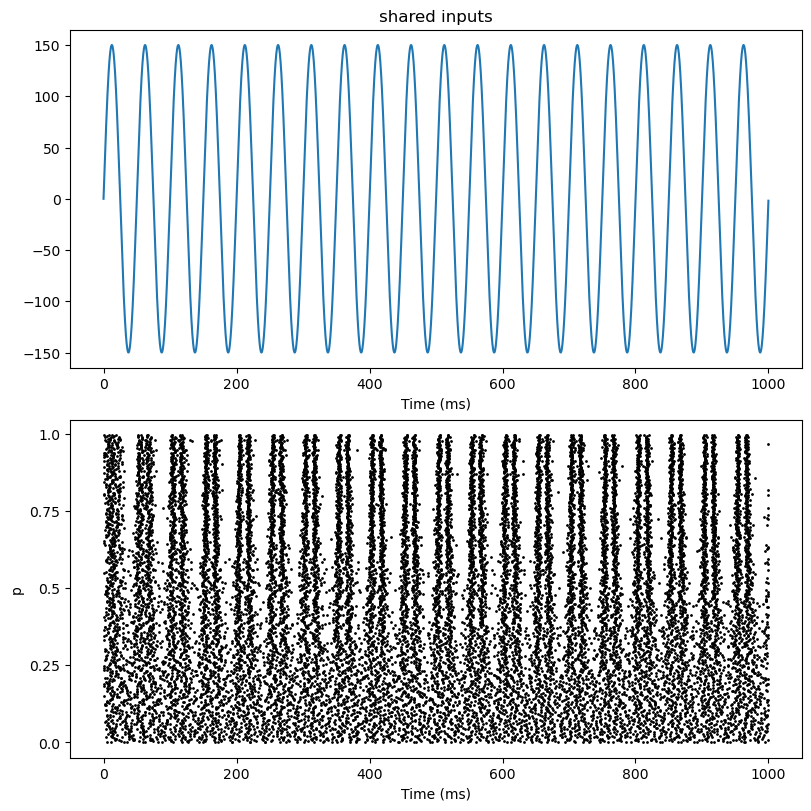

In [14]:
figure8(1.5)

In [15]:
def figure9(sigma):
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.p = bm.linspace(0., 1., num)
      # variables
      self.B = bm.Variable(bm.zeros(1))

    def update(self, _t, _dt):
      self.B[:] = bm.sin(40 * bm.pi * _t / 1000)  # (1,)
      self.I.value = 112.5 + (75 + 37.5 * self.p) * self.B + 37.5 * self.p  # (num,)

  num = 500
  # B should be a triangular wave taking values between -1 and 1, with
  # rising and falling time drawn uniformly between 10 ms and 50 ms.
  # While we use sin wave instead.
  model = LinearLeakyModel(num, inputs=Noise(num))
  model.sigma = sigma

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(2000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 12)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

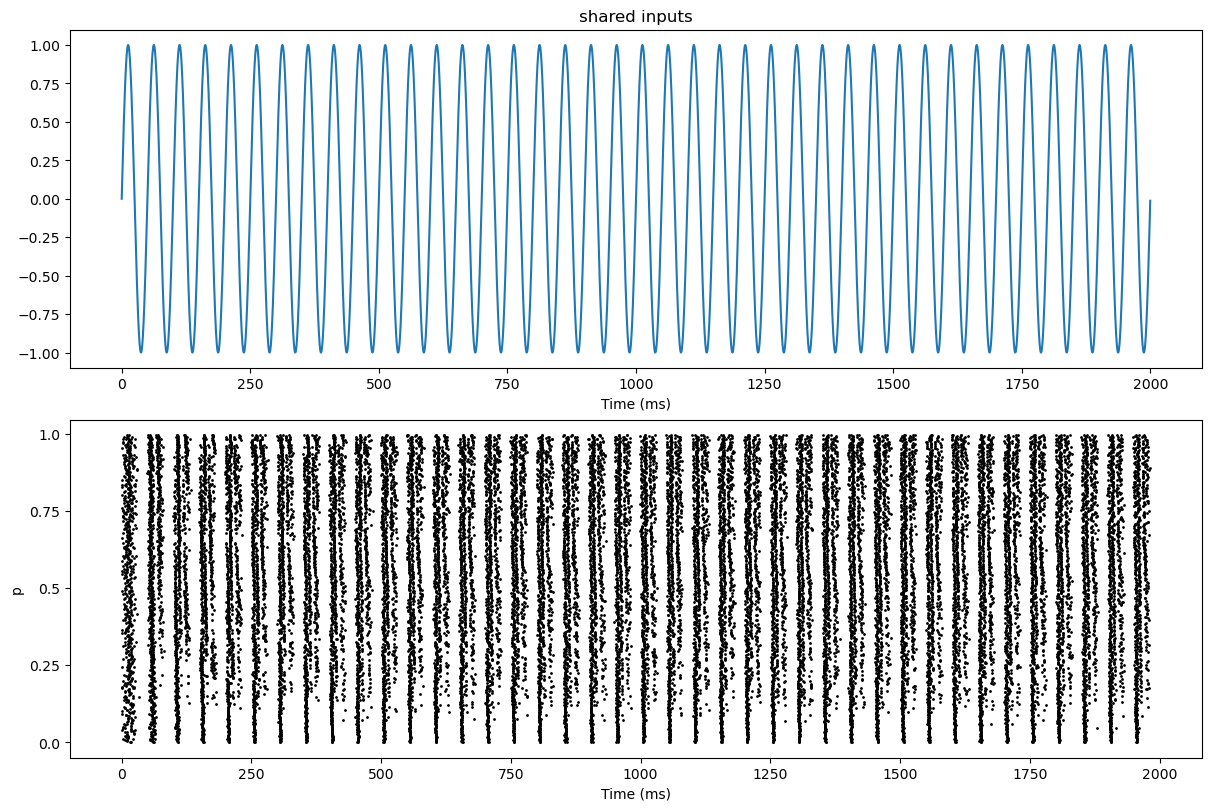

In [16]:
figure9(0.5)

In [17]:
def figure10():
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.tau = 10  # ms
      self.p = bm.linspace(0., 1., num)
      # variables
      self.x = bm.Variable(bm.zeros(1))
      self.B = bm.Variable(bm.zeros(1))
      # functions
      f = lambda x, t: -x / self.tau
      g = lambda x, t: bm.sqrt(2. / self.tau)
      self.integral = bp.sdeint(f=f, g=g)

    def update(self, _t, _dt):
      self.x.value = self.integral(self.x, _t, _dt)  # (1,)
      self.B.value = 2. / (1 + bm.exp(-2 * self.x)) - 1  # (1,)
      self.I.value = 0.5 + 3 * self.p * self.B  # (num,)

  num = 500
  model = NonLeakyModel(num, inputs=Noise(num))

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(1000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 8)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

In [18]:
def figure11(sigma):
  class Noise(ExternalInput):
    def __init__(self, num):
      super(Noise, self).__init__(num)
      # parameters
      self.tau = 10  # ms
      self.p = bm.linspace(0., 1., num)
      # variables
      self.x = bm.Variable(bm.zeros(1))
      self.B = bm.Variable(bm.zeros(1))
      # functions
      f = lambda x, t: -x / self.tau
      g = lambda x, t: bm.sqrt(2. / self.tau)
      self.integral = bp.sdeint(f=f, g=g)

    def update(self, _t, _dt):
      self.x.value = self.integral(self.x, _t, _dt)  # (1,)
      self.B.value = 2. / (1 + bm.exp(-2 * self.x)) - 1  # (1,)
      self.I.value = 0.5 + self.p * self.B  # (num,)

  num = 500
  model = PerfectIntegrator(num, inputs=Noise(num))
  model.sigma = sigma

  runner = bp.StructRunner(model, monitors=['inputs.B', 'spike'])
  runner.run(1000.)

  fig, gs = bp.visualize.get_figure(2, 1, 4, 8)
  fig.add_subplot(gs[0, 0])
  bp.visualize.line_plot(runner.mon.ts, runner.mon['inputs.B'], title='shared inputs')
  fig.add_subplot(gs[1, 0])
  bp.visualize.raster_plot(runner.mon.ts, runner.mon['spike'], ylabel='p')
  plt.yticks(bm.linspace(0, num, 5).numpy(), bm.linspace(0., 1., 5).numpy())
  plt.show()

  0%|          | 0/10000 [00:00<?, ?it/s]

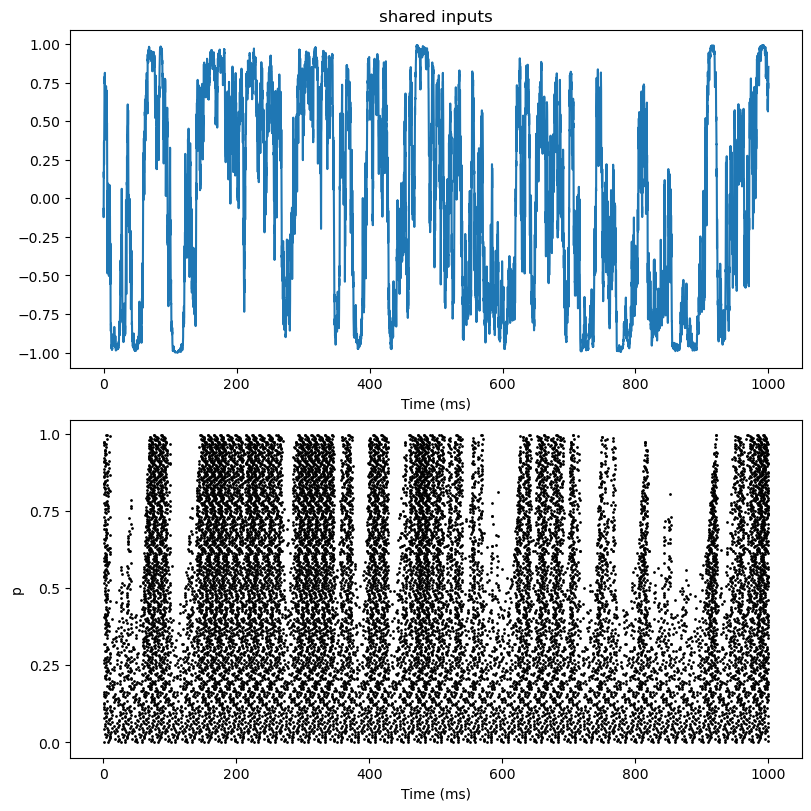

In [19]:
figure11(0.)

  0%|          | 0/10000 [00:00<?, ?it/s]

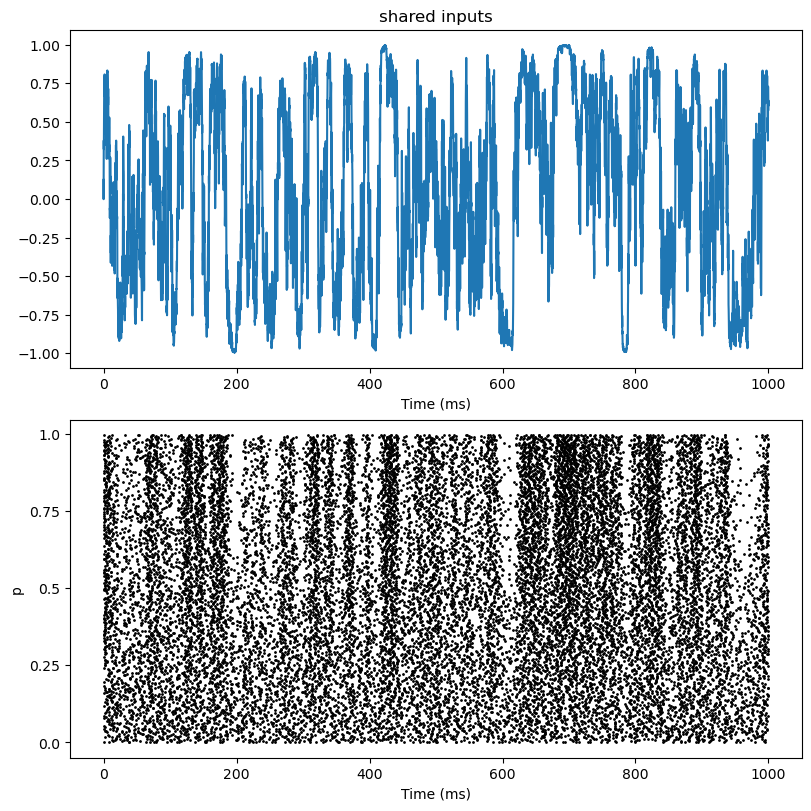

In [20]:
figure11(0.27)